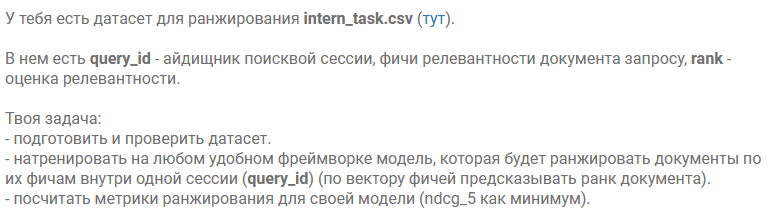

In [6]:
import re
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRanker
from scipy.stats import spearmanr

# 1. Подготовка и проверка датасета

## Смотрим структуру данных

In [59]:
data = pd.read_csv("intern_task.csv")
data.head(10)

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000
5,1,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.200000,0.974819,22.936731,0.333333,0.033233,0.000093,28.0,9.333333
6,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,3.0,16.200000,0.000000,0.945281,18.240926,0.000000,0.013008,0.000023,5.0,1.666667
7,0,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,0,10,2.0,0.0,1.0,0.0,2.0,0.666667,0.0,0.333333,...,218.0,55.069946,0.000000,0.448807,4.695805,0.000000,0.002153,0.000002,5.0,1.666667
9,0,10,3.0,0.0,0.0,0.0,3.0,1.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.975608,0.000000,0.000000,0.021583,0.000040,9.0,3.000000


In [60]:
data.describe()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.677869,14828.413401,1.911960,0.206233,1.189847,0.550272,1.960082,0.803964,0.097557,0.541174,...,4.763432e+02,1.046698e+04,0.070299,0.740710,11.067947,0.281747,0.027033,0.000269,22.457910,9.560379
std,0.830033,8193.945170,1.237374,0.579089,1.037233,0.790947,1.203534,0.339955,0.266035,0.419973,...,1.954840e+04,2.649584e+06,0.100721,0.352800,15.336861,0.392089,0.033351,0.002088,63.708018,14.347378
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8215.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.006703,0.000000,4.000000,2.000000
50%,0.000000,14935.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,9.448900,0.000000,0.017761,0.000008,12.000000,5.500000
75%,1.000000,21580.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,1.000000e+00,4.000000e-01,0.142857,0.999613,16.146733,0.500000,0.034954,0.000109,28.000000,12.000000
max,4.000000,29995.000000,31.000000,18.000000,27.000000,9.000000,31.000000,1.000000,1.000000,1.000000,...,1.731553e+06,8.000000e+08,0.818182,1.000000,2506.799764,1.000000,0.711261,0.250000,15074.000000,1552.000000


Находим и удаляем столбцы, которые во всех строках имеют одинаковое значение.

In [61]:
usless_columns = data.columns[data.nunique() == 1]
usless_columns_df = data[usless_columns]

data.drop(usless_columns, axis=1, inplace=True)
usless_columns_df.describe()

,feature_64,feature_65,feature_72,feature_100
count,235258.0,235258.0,235258.0,235258.0
mean,0.0,0.0,1.0,0.0
std,0.0,0.0,0.0,0.0
min,0.0,0.0,1.0,0.0
25%,0.0,0.0,1.0,0.0
50%,0.0,0.0,1.0,0.0
75%,0.0,0.0,1.0,0.0
max,0.0,0.0,1.0,0.0


Удаляем столбцы, корреляция между которыми равна 1.

In [62]:
сorrelation_columns = []

for col_i in data.columns:
    for col_j in data.columns:
        if ((np.corrcoef(data[col_i], data[col_j])[0, 1]) == 1) \
        and (col_i != col_j) \
        and (re.split('_', col_i)[-1] < re.split('_', col_j)[-1]):
            сorrelation_columns.append(col_i)
            print("Корреляция между", col_i, "и", col_j, " = 1")

columns_to_remove = list(set(сorrelation_columns))
data.drop(columns=columns_to_remove, inplace=True)

Корреляция между feature_20 и feature_8  = 1
Корреляция между feature_20 и feature_35  = 1
Корреляция между feature_35 и feature_8  = 1


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235258 entries, 0 to 235257
Columns: 140 entries, rank to feature_143
dtypes: float64(138), int64(2)
memory usage: 251.3 MB


Проверяем, есть ли среди значений NaN.

In [36]:
data.isnull().values.any()

False

Проверяем на наличие дублирующихся строк.

In [37]:
duplicate_rows = data.duplicated(keep=False)
print(data[duplicate_rows])

Empty DataFrame
Columns: [rank, query_id, feature_0, feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8, feature_9, feature_10, feature_11, feature_12, feature_13, feature_14, feature_15, feature_16, feature_17, feature_18, feature_19, feature_21, feature_22, feature_23, feature_24, feature_25, feature_26, feature_27, feature_28, feature_29, feature_30, feature_31, feature_32, feature_33, feature_34, feature_36, feature_37, feature_38, feature_39, feature_40, feature_41, feature_42, feature_43, feature_44, feature_45, feature_46, feature_47, feature_48, feature_49, feature_50, feature_51, feature_52, feature_53, feature_54, feature_55, feature_56, feature_57, feature_58, feature_59, feature_60, feature_61, feature_62, feature_63, feature_66, feature_67, feature_68, feature_69, feature_70, feature_71, feature_73, feature_74, feature_75, feature_76, feature_77, feature_78, feature_79, feature_80, feature_81, feature_82, feature_83, feature_84, feature_

Проверяем, отсортированы ли данные по query_id.

In [38]:
data['query_id'].is_monotonic_increasing

True

## Подготавливаем датасет

In [39]:
unique_query_ids = data['query_id'].unique()

val_size = 0.2

train_query_ids, val_query_ids = train_test_split(unique_query_ids, test_size=val_size, random_state=42)
train_data = data[data['query_id'].isin(train_query_ids)]
val_data = data[data['query_id'].isin(val_query_ids)]

In [40]:
qid_train = train_data['query_id'].values
qid_val = val_data['query_id'].values

X_train = train_data.drop(['rank', 'query_id'], axis=1)
y_train = train_data['rank']

X_val = val_data.drop(['rank', 'query_id'], axis=1)
y_val = val_data['rank']

max_relevance = np.max(y_train)
y_train /= max_relevance
y_val /= max_relevance

# 2. Обучение модели

In [41]:
train_pool = Pool(data=X_train,
                label = y_train,
                group_id=qid_train)

val_pool = Pool(data=X_val,
                label = y_val,
                group_id=qid_val)


In [52]:
default_parameters = {
    'iterations': 500,
    'max_bin': 256,
    'min_data_in_leaf': 32,
    'max_depth': 8,
    'verbose': 1,
    'boost_from_average': False,
    'early_stopping_rounds': 25,
    'random_seed': 0,
}


parameters = {}

def fit_model(loss_function: str,
              additional_params: dict = None,
              train_pool: Pool = train_pool,
              val_pool: Pool = val_pool
              ) -> CatBoostRanker:
    """
    Обучение модели CatBoost.

    Args:
        loss_function (str): Функция потерь для обучения модели.
        additional_params (dict, optional): Дополнительные параметры для модели. По умолчанию None.
        train_pool (CatBoostPool, optional): Пул данных для обучения. По умолчанию train_pool.
        val_pool (CatBoostPool, optional): Пул данных для тестирования. По умолчанию val_pool.

    Returns:
        CatBoostRanker: Обученная модель CatBoost.
    """
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=val_pool, plot=True)

    return model

In [ ]:
model = fit_model('YetiRank', {'custom_metric':
                ['PrecisionAt:top=10', 'PrecisionAt:top=5', 'PrecisionAt:top=3',
                'RecallAt:top=10', 'RecallAt:top=5', 'RecallAt:top=3',
                'MAP:top=10', 'MAP:top=5', 'MAP:top=3',
                'NDCG:top=10', 'NDCG:top=5', 'NDCG:top=3']})

Вычисляем коэффициент корреляции Спирмена между фактическими значениями целевой переменной (y_val) и предсказанными значениями, полученными с помощью модели (predictions).

In [54]:
predictions = model.predict(val_pool)
spearmanr(y_val, predictions)

SignificanceResult(statistic=0.39200874885232784, pvalue=0.0)

# 3. Подсчет метрик ранжирования

In [55]:
metrics = model.get_best_score()
pd.DataFrame(metrics).sort_index()

,learn,validation
MAP:top=10,0.172194,0.170560
MAP:top=3,0.190833,0.185486
MAP:top=5,0.172325,0.172032
NDCG:top=10;type=Base,NaN,0.574727
NDCG:top=3;type=Base,NaN,0.579114
NDCG:top=5;type=Base,NaN,0.571255
PFound,NaN,0.727806
PrecisionAt:top=10,0.103558,0.096250
PrecisionAt:top=3,0.184792,0.174167
PrecisionAt:top=5,0.145125,0.139000


Расчет значений метрик NDCG@3, NDCG@5 и NDCG@10 для каждого query_id и вычисление средних значений этих метрик по всем query_id.

In [57]:
def ndcg(y_score: np.ndarray, y_true: np.ndarray, k: int) -> float:
    """
    Вычисление метрики NDCG (Normalized Discounted Cumulative Gain).

    Args:
        y_score (np.ndarray): Предсказанные оценки.
        y_true (np.ndarray): Фактические оценки.
        k (int): Количество элементов для расчета метрики.

    Returns:
        float: Значение метрики NDCG.
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


ks = [3, 5, 10]
mean_ndcgs = []


for k in ks:
    ndcg_values = []

    for qid in np.unique(qid_val):
        y = y_val[qid_val == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_val[qid_val == qid])

        idcg = ndcg(y, y, k)
        ndcg_values.append(ndcg(p, y, k) / idcg)

    mean_ndcg = np.mean(ndcg_values)
    mean_ndcgs.append(mean_ndcg)

for i, k in enumerate(ks):
    print(f"NDCG@{k}:", mean_ndcgs[i])

NDCG@3: 0.5423060414378481
NDCG@5: 0.5364453299093433
NDCG@10: 0.5428459459649844
